## Load the dataset report

The JSON report is generated by ``dataset_forest_report.py``. Each entry contains metadata about the dataset alongside summary statistics for the optimised Random Forest model.

In [56]:
import sys

from __future__ import annotations

from pathlib import Path
from typing import Any, Mapping
import json

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')
REPORT_PATH = Path('forest_report.json')
REPORT_PATH.resolve()

with REPORT_PATH.open('r', encoding='utf-8') as handle:
    report_data: list[dict[str, Any]] = json.load(handle)

## Build a summary table

We reuse the Random Forest estimator counts reported in ``forest_report.json`` to build a sortable summary. This mirrors the CLI behaviour after switching to raw estimator counts.

In [57]:
def to_int(value: Any | None) -> int | None:
    try:
        return int(value)
    except (TypeError, ValueError):
        return None


def to_float(value: Any | None) -> float | None:
    try:
        return float(value)
    except (TypeError, ValueError):
        return None


def extract_metadata(entry: Mapping[str, Any]) -> dict[str, Any]:
    metadata = entry.get('metadata')
    if not isinstance(metadata, Mapping):
        metadata = {}

    statistics = entry.get('forest_statistics')
    if not isinstance(statistics, Mapping):
        statistics = {}

    dataset = str(entry.get('dataset', '')) or '<unknown>'

    return {
        'dataset': dataset,
        'n_estimators': to_int(statistics.get('n_estimators')),
        'series_length': to_int(metadata.get('series_length')),
        'train_size': to_int(metadata.get('train_size')),
        'test_size': to_int(metadata.get('test_size')),
        'avg_depth': to_float(statistics.get('avg_depth')),
        'avg_leaves': to_float(statistics.get('avg_leaves')),
        'avg_nodes': to_float(statistics.get('avg_nodes')),
    }


# Build summary dataframe from forest_report.json
summary_rows = [extract_metadata(entry) for entry in report_data]
summary_df = pd.DataFrame(summary_rows)

# Load EU data from forest_report.json
eu_metrics = {}

for entry in report_data:
    try:
        dataset_name = str(entry.get('dataset', '')).strip()
        if not dataset_name:
            continue

        n_features = entry.get('n_features') if isinstance(entry.get('n_features'), (int, float)) else None
        mean_eu = entry.get('mean_eu') if isinstance(entry.get('mean_eu'), (int, float)) else None
        eu_complexity = entry.get('eu_complexity') if isinstance(entry.get('eu_complexity'), (int, float)) else None

        lengths = None
        eu_obj = entry.get('endpoints_universe') or entry.get('endpoints') or entry.get('endpoints_universe_summary')
        if isinstance(eu_obj, dict):
            lens = []
            for feature_name, endpoints in eu_obj.items():
                if isinstance(endpoints, (list, tuple)):
                    lens.append(len(endpoints))
            if lens:
                lengths = lens
                computed_n = len(lens)
                computed_mean = float(np.mean(lens))
                computed_complexity = computed_mean * computed_n
                if n_features is None:
                    n_features = computed_n
                if mean_eu is None:
                    mean_eu = computed_mean
                if eu_complexity is None:
                    eu_complexity = computed_complexity

        if lengths is None and n_features is not None and mean_eu is not None:
            lengths = None

        if n_features is not None and mean_eu is not None:
            eu_metrics[dataset_name] = {
                'n_features': int(n_features),
                'mean_eu': float(mean_eu),
                'eu_complexity': float(eu_complexity) if eu_complexity is not None else float(mean_eu) * int(n_features),
                'lengths': lengths
            }
    except Exception:
        continue

print(f"Built EU metrics for {len(eu_metrics)} datasets from forest_report.json entries")

summary_df['n_features'] = summary_df['dataset'].apply(
    lambda d: eu_metrics[d]['n_features'] if d in eu_metrics else None
)
summary_df['mean_eu'] = summary_df['dataset'].apply(
    lambda d: eu_metrics[d]['mean_eu'] if d in eu_metrics else None
)
summary_df['eu_complexity'] = summary_df['dataset'].apply(
    lambda d: eu_metrics[d]['eu_complexity'] if d in eu_metrics else None
)

# Check if dataset has results in the results/ folder
from pathlib import Path
results_dir = Path('results')
if results_dir.exists():
    result_files = [f.name for f in results_dir.iterdir() if f.is_file() and f.suffix == '.zip']
    # Extract dataset names from filenames (format: DatasetName_label_flag_num.zip)
    datasets_with_results = set()
    for filename in result_files:
        # Split by underscore and take the first part as dataset name
        dataset_name = filename.split('_')[0]
        datasets_with_results.add(dataset_name)
    
    summary_df['analyzed'] = summary_df['dataset'].apply(
        lambda d: 'YES' if d in datasets_with_results else 'NO'
    )
    print(f"Found results for {len(datasets_with_results)} datasets in results/ folder")
else:
    summary_df['analyzed'] = 'N/A'
    print("Warning: results/ folder not found")

summary_df = summary_df[[
    'dataset', 'analyzed', 'n_estimators', 'eu_complexity', 'series_length',
    'n_features', 'mean_eu',
    'avg_depth', 'avg_leaves', 'avg_nodes',
    'train_size', 'test_size'
]]

# Sorting logic:
# 1. n_estimators (primary)
# 2. eu_complexity if present, otherwise series_length (secondary)
# 3. series_length always (tertiary)
# 4. dataset name (quaternary)
summary_df['_sort_n_estimators'] = summary_df['n_estimators'].fillna(float('inf'))
summary_df['_sort_eu'] = summary_df.apply(
    lambda row: row['eu_complexity'] if pd.notna(row['eu_complexity']) else (row['series_length'] if pd.notna(row['series_length']) else float('inf')),
    axis=1
)
summary_df['_sort_series_length'] = summary_df['series_length'].fillna(float('inf'))

summary_df = summary_df.sort_values(
    ['_sort_n_estimators', '_sort_eu', '_sort_series_length', 'dataset'],
    ascending=[True, True, True, True]
).drop(columns=['_sort_n_estimators', '_sort_eu', '_sort_series_length']).reset_index(drop=True)

from etl.table_styling import style_summary_table, print_color_legend

# Mostra la legenda dei colori per capire la mappatura cromatica
print_color_legend()
print("\n" + "="*80 + "\n")

# Applica lo styling completo a tutte le colonne e mostra la tabella
styled_summary = style_summary_table(summary_df)
styled_summary

Built EU metrics for 87 datasets from forest_report.json entries
Found results for 7 datasets in results/ folder
COLUMN COLOR GRADIENTS
  n_estimators         → Reds (white → red)
  eu_complexity        → Oranges (white → orange)
  series_length        → YlOrBr (yellow → orange → brown)
  n_features           → YlGn (yellow → green)
  mean_eu              → Greens (white → green)
  avg_depth            → GnBu (green → blue)
  avg_leaves           → Blues (white → blue)
  avg_nodes            → BuPu (blue → purple)
  train_size           → Purples (white → purple)
  test_size            → RdPu (red → purple)
  analyzed             → Green (YES) / Red (NO)




,dataset,analyzed,n_estimators,eu_complexity,series_length,n_features,mean_eu,avg_depth,avg_leaves,avg_nodes,train_size,test_size
0,Wine,NO,10,297,234,86,3.45,2.60,4.40,7.80,57,54
1,Wafer,YES,10,603,152,129,4.67,6.80,13.20,25.40,"1,000","6,164"
2,MiddlePhalanxOutlineCorrect,YES,10,"1,440",80,80,18.00,8.00,35.60,70.20,600,291
3,MelbournePedestrian,YES,10,"1,456",24,24,60.67,9.30,40.20,79.40,"1,138","2,319"
4,ChlorineConcentration,YES,10,"1,792",166,166,10.80,15.10,39.40,77.80,467,"3,840"
5,ScreenType,NO,10,"2,618",720,600,4.36,0.20,1.20,1.40,375,375
6,FordA,NO,10,"8,811",500,500,17.62,10.30,30.00,59.00,"3,601","1,320"
7,FordB,NO,10,"8,964",500,500,17.93,12.20,30.00,59.00,"3,636",810
8,ElectricDevices,YES,10,"29,847",96,96,310.91,26.60,360.90,720.80,"8,926","7,711"
9,SonyAIBORobotSurface1,YES,17,106,70,32,3.31,1.65,2.71,4.41,20,601


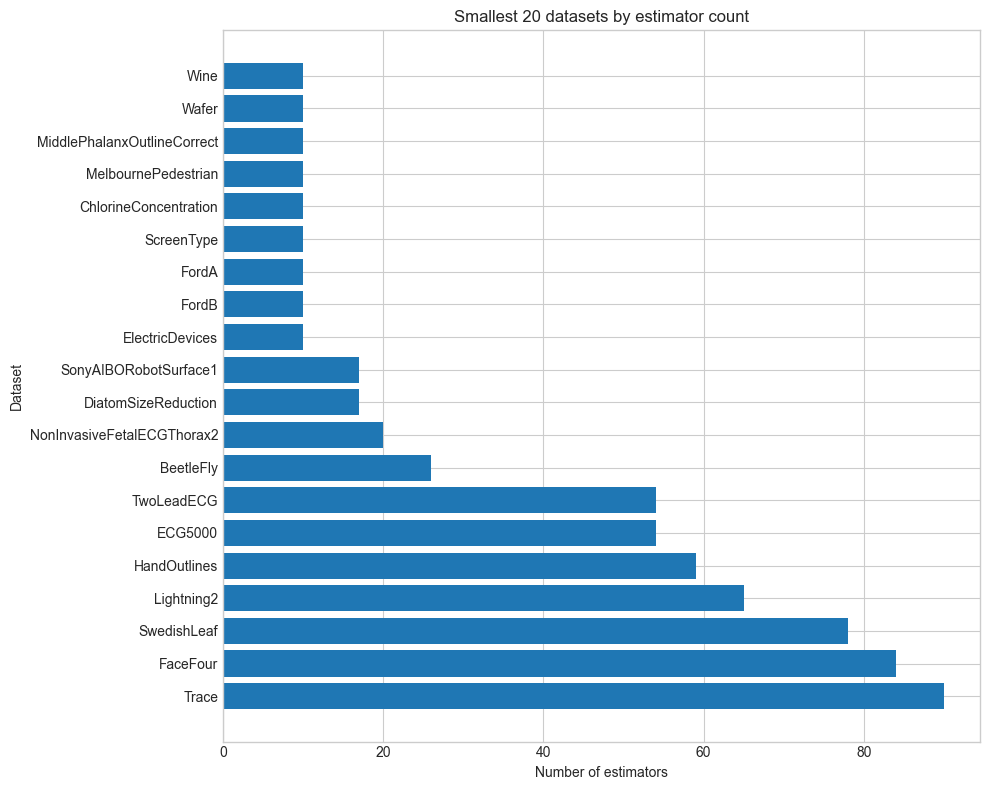

In [58]:
smallest_n = 20
least_complex = summary_df.head(smallest_n)
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(least_complex['dataset'], least_complex['n_estimators'], color='#1f77b4')
ax.set_xlabel('Number of estimators')
ax.set_ylabel('Dataset')
ax.set_title(f'Smallest {smallest_n} datasets by estimator count')
ax.invert_yaxis()
plt.tight_layout()
plt.show()
